In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.nn import init
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor

In [2]:
areanumbers = [18]#,2,3,3,5,6,7,8,9,10,11,12,13,14,15,16]

batchsize=1
#Train 80% of the dataset 4014
train_test_split =3208
val_amount = 0

def hours_to_datestring(t):
    t=int(t)
    start = datetime.datetime(1950,1,1)
    delta = datetime.timedelta(hours=t)
    return (start+delta).strftime('%Y-%m-%d %H:%M:%S')
# Limit to 2017-12-23 for standardisation
times = np.load('dataset/times.npy')[:365*11]
print(hours_to_datestring(times[0]))
print(hours_to_datestring(times[3292]))

areatemps=[]
for i in areanumbers:
    print(i)
    nextarea = (np.load(f'dataset/by-area/area{i}.npy')[:365*11])
    # Ignore leap days
    for j in range(365):
        days = nextarea[j::365]
        days -= np.mean(days)
        days /= np.std(days)
    areatemps.append(nextarea)
areatemps = np.array(areatemps)
print(nextarea.shape)

def input_indices(end_indices):
    a = end_indices[:,None]
    return np.concatenate((a-4,a-3,a-2,a-1),axis=1)

def new_size(size):
    return torch.Size((size[0]*size[1],))+size[2:]
#train_val_beginnings = 4+np.random.permutation(train_test_split-4)
train_val_beginnings = 4+np.arange(train_test_split-4)

train_inputs = torch.from_numpy(areatemps[:,input_indices(train_val_beginnings[val_amount:])]).type(dtype)
train_inputs = train_inputs.view(new_size(train_inputs.size()))
print(train_inputs.shape)

train_ends = torch.from_numpy(areatemps[:,train_val_beginnings[val_amount:]]).type(dtype)
train_ends = train_ends.view(new_size(train_ends.size()))
print(train_ends.shape)

train_data = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_inputs,train_ends),
                                         batch_size=batchsize, shuffle=True
                                        )

test_inputs = torch.from_numpy(areatemps[:,train_test_split+4:]).type(dtype)
test_inputs = test_inputs.view(new_size(test_inputs.size()))
print(test_inputs.shape)

test_ends = torch.from_numpy(areatemps[:,input_indices(np.arange(train_test_split+4,areatemps.shape[1]))]).type(dtype)
test_ends = test_ends.view(new_size(test_ends.size()))
print(test_ends.shape)

test_data = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_ends,test_inputs),
                                         batch_size=batchsize, shuffle=False
                                        )

2006-12-27 12:00:00
2016-01-01 12:00:00
18
(4015, 64, 64)
torch.Size([3204, 4, 64, 64])
torch.Size([3204, 64, 64])
torch.Size([803, 64, 64])
torch.Size([803, 4, 64, 64])


In [3]:
def k(distsq,D,dt):
    return torch.exp(-distsq/(4*D*dt))/(4*np.pi*D*dt)
def gradientk(dist,D,dt):
    return dist*torch.exp(-(dist**2).sum(1)/(4*D*dt))/(8*np.pi*D**2*dt**2)
class GaussianConvolution(Function):
    D = 0.45
    dt = 1
    @staticmethod
    def forward(ctx, w, I):
        ctx.save_for_backward(w,I)
        interval=torch.arange(I.size()[-1]).type(dtype)
        x1 = interval[None,:,None,None,None]
        x2 = interval[None,None,:,None,None]
        y1 = interval[None,None,None,:,None]
        y2 = interval[None,None,None,None,:]
        distsq = (x1-y1-w[:,0,:,:,None,None])**2+(x2-y2-w[:,1,:,:,None,None])**2
        return (I[:,None,None,:,:]*k(distsq,GaussianConvolution.D,GaussianConvolution.dt)).sum(4).sum(3)
    
    @staticmethod
    def backward(ctx, grad_output):
        w,I = ctx.saved_variables
        w=w.data
        I=I.data
        interval=torch.arange(I.size()[-1]).type(dtype)
        x1 = interval[None,:,None,None,None]
        x2 = interval[None,None,:,None,None]
        y1 = interval[None,None,None,:,None]
        y2 = interval[None,None,None,None,:]
        distx = (x1-w[:,0,:,:,None,None]-y1)[:,None,:,:,:,:].repeat(1,1,1,1,1,I.size()[-1])
        disty = (x2-w[:,1,:,:,None,None]-y2)[:,None,:,:,:,:].repeat(1,1,1,1,I.size()[-1],1)
        dist = torch.cat((distx,disty),dim=1)
        grad = Variable((I[:,None,None,:,:]*gradientk(dist,GaussianConvolution.D,GaussianConvolution.dt)).sum(5).sum(4), requires_grad=False)
        #I(x) only depends on w(x) and not on w(z) for z != x
        return grad*grad_output[:,None,:,:], None

In [4]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                #nn.init.kaiming_normal(module.weight)
                #nn.init.normal(module.weight, mean=0, std=0.01)
                nn.init.xavier_normal(module.weight, gain=1)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_EncoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 =  nn.BatchNorm2d(in_channels)
        self.lr1 =  nn.LeakyReLU(0.1,inplace=True)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 =  nn.BatchNorm2d(out_channels)
        self.lr2 =  nn.LeakyReLU(0.1,inplace=True)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=1)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.maxp(out)
        return out

class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.cv1 =     nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 =     nn.BatchNorm2d(in_channels)
        self.lr1 =     nn.LeakyReLU(0.1,inplace=True)
        self.cv2 =     nn.Conv2d(in_channels, middle_channels, kernel_size=3)
        self.bn2 =     nn.BatchNorm2d(middle_channels)
        self.lr2 =     nn.LeakyReLU(0.1,inplace=True)
        self.tcv =     nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class _CenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_CenterBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels,in_channels , kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1,inplace=True)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.lr2 = nn.LeakyReLU(0.1,inplace=True)
        self.tcv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.lr1(out)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class CDNN(nn.Module):
    def __init__(self,k):
        super(CDNN, self).__init__()
        self.enc1 = _EncoderBlock(k,64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512)
        self.dec4= _CenterBlock(512, 386)
        self.dec3 = _DecoderBlock(386+256, 256, 194)
        self.dec2 = _DecoderBlock(194+128, 128, 98)
        self.dec1 = _DecoderBlock(98+64, 64, 2)
        self.final = nn.Sequential(
            nn.Conv2d(2,2, kernel_size=3),
        )
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        #print("x",x.shape)
        #print("enc1",enc1.shape)
        enc2 = self.enc2(enc1)
        #print("enc2",enc2.shape)
        enc3 = self.enc3(enc2)
        #print("enc3",enc3.shape)
        enc4 = self.enc4(enc3)
        #print("enc4",enc4.shape)
        dec4 = self.dec4(enc4)
        #print("dec4",dec4.shape)
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        #print("dec3",dec3.shape)
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        #print("dec2",dec2.shape)
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        W=F.upsample(final, x.size()[2:], mode='bilinear')
        #print("W",W.shape)

        return W

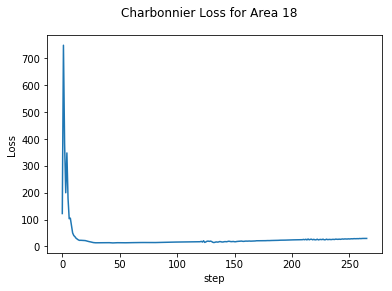

In [5]:
# Load CDNN for evaluation
net = CDNN(4)

filename="/home/thanos/Desktop/MLCV/models/Charbonnier/CDNN_Charbonnier_Epoch=27.pth"
torch.load(filename)
checkpoint = torch.load(filename)
net.load_state_dict(checkpoint['state_dict'])
L=checkpoint['losses']

#Evaluation mode
net.eval()

plt.figure()
plt.plot(L)
plt.xlabel('step')
plt.ylabel('Loss')
plt.suptitle("Charbonnier Loss for Area {0}".format(areanumbers[0]))
plt.show()

In [6]:
warping = GaussianConvolution.apply
loss_fn = torch.nn.MSELoss(size_average=True)

Error = []
step=0
for data in test_data:
    Input, Target = data
    
    Input = Variable(Input,requires_grad=False)
    Target = Variable(Target)
    
    
    
    w = net(Input)
    y_pred = warping(w, Input[:,-1])
    step=step+1
    loss = loss_fn(y_pred, Target)
    #print(step,loss.data[0])
    Error.append(loss.data[0])
    
    
    
print("MSE = ",np.mean(Error))

KeyboardInterrupt: 

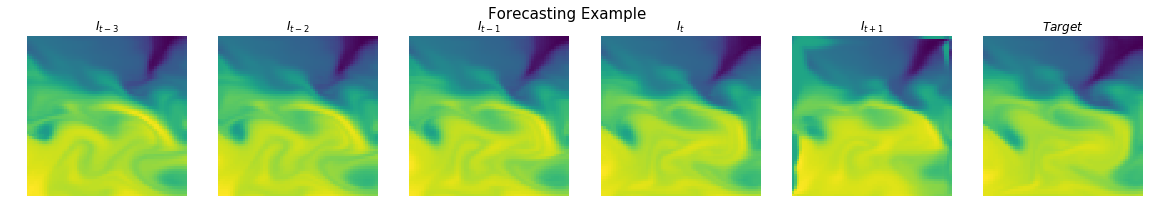

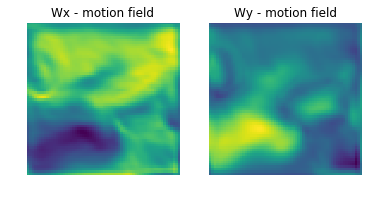

In [7]:
plt.figure(figsize=(20,15))
plt.suptitle("Forecasting Example",y=0.81,fontsize=15)
plt.subplot(261).axis("off")
plt.imshow(Input.data[0,0,:,:].numpy(),origin='lower')
plt.title("$I_{t-3}$")
plt.subplot(262).axis("off")
plt.imshow(Input.data[0,1,:,:].numpy(),origin='lower')
plt.title("$I_{t-2}$")
plt.subplot(263).axis("off")
plt.imshow(Input.data[0,2,:,:].numpy(),origin='lower')
plt.title("$I_{t-1}$")
plt.subplot(264).axis("off")
plt.imshow(Input.data[0,3,:,:].numpy(),origin='lower')
plt.title("$I_{t}$")
plt.subplot(265).axis("off")
plt.imshow(y_pred.data[0].numpy(),origin='lower')
plt.title("$I_{t+1}$")
plt.subplot(266).axis("off")
plt.imshow(Target.data[0].numpy(),origin='lower')
plt.title("$Target$")
plt.show()

plt.figure()
plt.subplot(121).axis("off")
plt.imshow(w.data[0,0,:,:])
plt.title("Wx - motion field")
plt.subplot(122).axis("off")
plt.imshow(w.data[0,1,:,:])
plt.title("Wy - motion field")
plt.show()

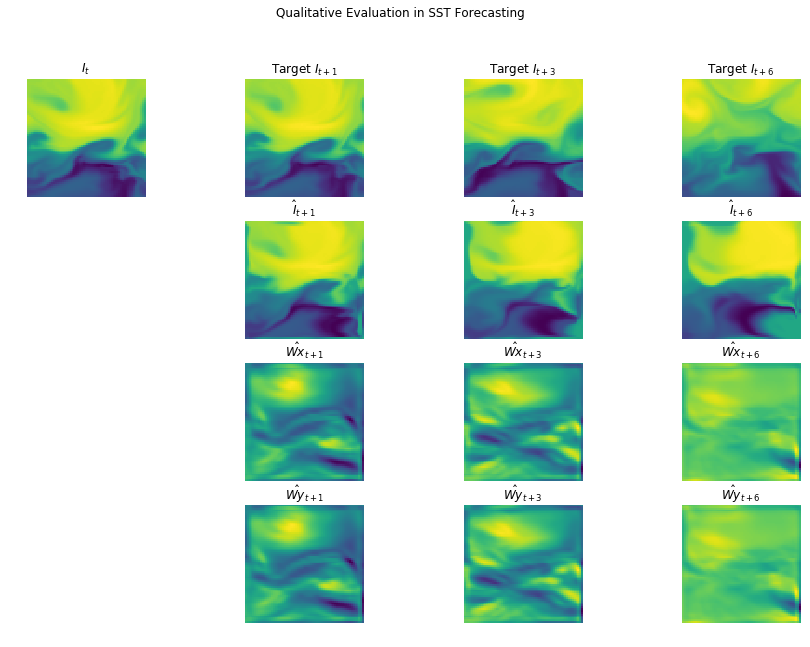

In [8]:
Input2=torch.FloatTensor(1,4,64,64)
Input3=torch.FloatTensor(1,4,64,64)
Input4=torch.FloatTensor(1,4,64,64)
Input5=torch.FloatTensor(1,4,64,64)
Input6=torch.FloatTensor(1,4,64,64)

Input, Target1 = next(iter(train_data))

Input = Variable(Input,requires_grad=False)

w1 = net(Input)
I1 = warping(w1, Input[:,-1])

Input2[0,0,:,:]=Input.data[0,1,:,:]
Input2[0,1,:,:]=Input.data[0,2,:,:]
Input2[0,2,:,:]=Input.data[0,3,:,:]
Input2[0,3,:,:]=I1.data[0]
Input2 = Variable(Input2,requires_grad=False)

w2 = net(Input2)
I2 = warping(w2, Input2[:,-1])
temp, Target2 = next(iter(train_data))

Input3[0,0,:,:]=Input2.data[0,1,:,:]
Input3[0,1,:,:]=Input2.data[0,2,:,:]
Input3[0,2,:,:]=Input2.data[0,3,:,:]
Input3[0,3,:,:]=I2.data[0]
Input3 = Variable(Input3,requires_grad=False)

w3 = net(Input3)
I3 = warping(w3, Input3[:,-1])
temp, Target3 = next(iter(train_data))

Input4[0,0,:,:]=Input3.data[0,1,:,:]
Input4[0,1,:,:]=Input3.data[0,2,:,:]
Input4[0,2,:,:]=Input3.data[0,3,:,:]
Input4[0,3,:,:]=I3.data[0]
Input4 = Variable(Input4,requires_grad=False)

w4 = net(Input4)
I4 = warping(w4, Input4[:,-1])
temp, Target4 = next(iter(train_data))

Input5[0,0,:,:]=Input4.data[0,1,:,:]
Input5[0,1,:,:]=Input4.data[0,2,:,:]
Input5[0,2,:,:]=Input4.data[0,3,:,:]
Input5[0,3,:,:]=I4.data[0]
Input5 = Variable(Input5,requires_grad=False)

w5 = net(Input5)
I5 = warping(w5, Input5[:,-1])
temp, Target5 = next(iter(train_data))


Input6[0,0,:,:]=Input5.data[0,1,:,:]
Input6[0,1,:,:]=Input5.data[0,2,:,:]
Input6[0,2,:,:]=Input5.data[0,3,:,:]
Input6[0,3,:,:]=I5.data[0]
Input6 = Variable(Input6,requires_grad=False)

w6 = net(Input6)
I6 = warping(w6, Input6[:,-1])
temp, Target6 = next(iter(train_data))

plt.figure(figsize=(15,10))
plt.suptitle("Qualitative Evaluation in SST Forecasting")
plt.subplot(4,4,1).axis("off")
plt.imshow(Input.data[0,3,:,:])
plt.title("$I_{t}$")
plt.subplot(4,4,2).axis("off")
plt.imshow(Target1[0,:,:])
plt.title("Target $I_{t+1}$")
plt.subplot(4,4,3).axis("off")
plt.imshow(Target3[0,:,:])
plt.title("Target $I_{t+3}$")
plt.subplot(4,4,4).axis("off")
plt.imshow(Target6[0,:,:])
plt.title("Target $I_{t+6}$")
#
plt.subplot(4,4,6).axis("off")
plt.imshow(I1.data[0,:,:])
plt.title("$\hat{I}_{t+1}$")
plt.subplot(4,4,7).axis("off")
plt.imshow(I3.data[0,:,:])
plt.title("$\hat{I}_{t+3}$")
plt.subplot(4,4,8).axis("off")
plt.imshow(I6.data[0,:,:])
plt.title("$\hat{I}_{t+6}$")
#
plt.subplot(4,4,10).axis("off")
plt.imshow(w1.data[0,0,:,:])
plt.title("$\hat{Wx}_{t+1}$")
plt.subplot(4,4,11).axis("off")
plt.imshow(w3.data[0,0,:,:])
plt.title("$\hat{Wx}_{t+3}$")
plt.subplot(4,4,12).axis("off")
plt.imshow(w6.data[0,0,:,:])
plt.title("$\hat{Wx}_{t+6}$")
#
plt.subplot(4,4,14).axis("off")
plt.imshow(w1.data[0,0,:,:])
plt.title("$\hat{Wy}_{t+1}$")
plt.subplot(4,4,15).axis("off")
plt.imshow(w3.data[0,0,:,:])
plt.title("$\hat{Wy}_{t+3}$")
plt.subplot(4,4,16).axis("off")
plt.imshow(w6.data[0,0,:,:])
plt.title("$\hat{Wy}_{t+6}$")
plt.show()
